***Preparar el modelo RF***

In [225]:
#importar bibliotecas
import pandas as pd
from sklearn.calibration import cross_val_predict
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, roc_curve, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import joblib
from sklearn.utils import shuffle
import time
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [226]:
# Cargar el archivo CSV con el df limpio 
file_path = '../Archivos/data_clean.csv'
df = pd.read_csv(file_path)

In [227]:
df.shape

(8693, 15)

In [228]:
# Usar una muestra de 5000 filas para la búsqueda de hiperparámetros
sample_size = 5000
df_sample = shuffle(df, random_state=42).iloc[:sample_size]

In [229]:
X_sample = df_sample.drop(columns=[ 'Transported'])
y_sample = df_sample['Transported']

In [230]:
# Preparar todo el dataset para el entrenamiento final
X_full = df.drop(columns=['Transported'])
y_full = df['Transported']

In [231]:
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=42, stratify=y_full)

In [232]:

# Configurar la validación cruzada con K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

In [233]:
# Definir el espacio de búsqueda de hiperparámetros para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10,20,None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', 'log2']}

In [234]:
print(param_grid_rf)

{'n_estimators': [100, 200, 300], 'max_depth': [10, 20, None], 'min_samples_split': [2, 10], 'min_samples_leaf': [1, 4], 'max_features': ['sqrt', 'log2']}


In [235]:
# Configurar la búsqueda de hiperparámetros para Random Forest
rf_model = RandomForestClassifier(n_estimators=100,random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [236]:
# Obtener la importancia de las características
importances = rf_model.feature_importances_

# Crear un DataFrame para visualizar la importancia
feature_importances = pd.DataFrame({
    'Feature': X_full.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

In [237]:
feature_importances

,Feature,Importance
0,PassengerId,0.121067
12,Num,0.120681
4,Age,0.107535
9,Spa,0.099387
6,RoomService,0.096912
10,VRDeck,0.093327
2,CryoSleep,0.089629
7,FoodCourt,0.081968
8,ShoppingMall,0.059347
11,Deck,0.049061


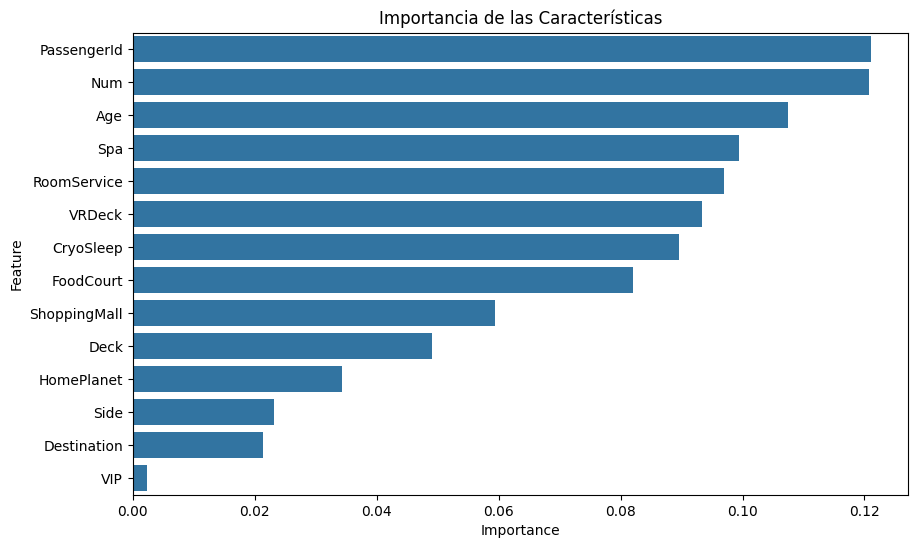

In [238]:
# Visualizar la importancia
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Importancia de las Características')
plt.show()

In [239]:
# Realizar la búsqueda de hiperparámetros con la muestra
print("Iniciando búsqueda de hiperparámetros...")
start_time = time.time()
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=kf, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_rf.fit(X_sample, y_sample)
end_time = time.time()
print(f"Búsqueda de hiperparámetros completada en {end_time - start_time:.2f} segundos")

Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Búsqueda de hiperparámetros completada en 180.10 segundos


In [240]:
# Evaluar el modelo con validación cruzada
cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='accuracy')
y_pred = cross_val_predict(best_rf_model, X_test, y_test, cv=5)
y_pred_proba = cross_val_predict(best_rf_model, X_test, y_test, cv=5, method='predict_proba')[:, 1]

In [241]:
# Métricas con pos_label especificado
conf_matrix = confusion_matrix(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

In [242]:
# Evaluar el modelo en el conjunto de entrenamiento
y_pred_train = rf_model.predict(X_train)

In [243]:
# Métricas para el conjunto de entrenamiento
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, pos_label=1)
recall_train = recall_score(y_train, y_pred_train, pos_label=1)
f1_train = f1_score(y_train, y_pred_train, pos_label=1)

In [244]:
# Imprimir métricas para entrenamiento y prueba
print(f"Entrenamiento: Accuracy: {accuracy_train:.2f}, Precision: {precision_train:.2f}, Recall: {recall_train:.2f}, F1 Score: {f1_train:.2f}")
print(f"Prueba: Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

Entrenamiento: Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Prueba: Accuracy: 0.79, Precision: 0.79, Recall: 0.78, F1 Score: 0.79


***Entrenar el rf con las caracteristicas mejores***

In [245]:
top_n_features = feature_importances.head(10)['Feature']
X_train_selected = X_train[top_n_features]
X_test_selected = X_test[top_n_features]

In [246]:
model_selected = RandomForestClassifier(n_estimators=100, random_state=42)
model_selected.fit(X_train_selected, y_train)

RandomForestClassifier(random_state=42)

In [247]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model_selected.predict(X_test_selected)

print("Accuracy:", accuracy_score(y_test, y_pred)) 
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7822085889570553
Classification Report:
               precision    recall  f1-score   support

       False       0.76      0.82      0.79      1295
        True       0.81      0.75      0.78      1313

    accuracy                           0.78      2608
   macro avg       0.78      0.78      0.78      2608
weighted avg       0.78      0.78      0.78      2608



In [255]:
# Evaluar el modelo ajustado en el conjunto de test####
import pandas as pd
X_saved = pd.read_csv('../Archivos/test_clean.csv') #limpio
X_saved


,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Num,Side
0,0013_01,0,1,2,27,0,0,0,0,0,0,6,3,1
1,0018_01,0,0,2,19,0,0,9,0,724,0,5,4,1
2,0019_01,1,1,0,31,0,0,0,0,0,0,2,0,1
3,0021_01,1,0,2,38,0,0,843,0,155,359,2,1,1
4,0023_01,0,0,2,20,0,10,0,366,0,0,5,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,0,1,2,34,0,0,0,0,0,0,6,1496,1
4273,9269_01,0,0,2,42,0,0,468,17,10,131,5,4,1
4274,9271_01,2,1,0,26,0,0,0,0,0,0,3,296,0
4275,9273_01,1,0,2,26,0,0,712,0,0,334,3,297,0


In [256]:
X_saved.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Deck',
       'Num', 'Side'],
      dtype='object')

In [260]:
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_saved)

n_predictions = (y_pred_rf > 0.5).astype(bool)
submission_id = X_saved['PassengerId']
output = pd.DataFrame({'PassengerId': submission_id,
                       'Transported': n_predictions.squeeze()})

output.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [258]:
# Imprimir métricas para prueba

print(f"Prueba: Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

Prueba: Accuracy: 0.79, Precision: 0.79, Recall: 0.78, F1 Score: 0.79


***Guardar predicciones para los Pasajeros***

In [276]:
sample_submission_df = pd.read_csv('../Archivos/test_clean.csv')
sample_submission_df['Transported'] = n_predictions

output_df = sample_submission_df[['PassengerId', 'Transported']]
output_df.to_csv('../Archivos/sample_submission.csv', index=False)
output_df.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [277]:
output_df.shape

(4277, 2)

In [275]:
import pandas as pd
df1 = pd.read_csv('../Archivos/sample_submission.csv')
df1 

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False
